In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, TimeDistributed, LSTM, Lambda
from keras.layers import AveragePooling2D, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.applications.xception import Xception
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import sklearn.metrics as metrics

import numpy as np
import pandas as pd

import pickle
import sys, gc, os
import glob
import psutil

import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.


In [2]:

_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None


def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def correct_pad(backend, inputs, kernel_size):
    """Returns a tuple for zero-padding for 2D convolution with downsampling.
    # Arguments
        input_size: An integer or tuple/list of 2 integers.
        kernel_size: An integer or tuple/list of 2 integers.
    # Returns
        A tuple.
    """
    img_dim = 2 if backend.image_data_format() == 'channels_first' else 1
    input_size = backend.int_shape(inputs)[img_dim:(img_dim + 2)]

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)

    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

    correct = (kernel_size[0] // 2, kernel_size[1] // 2)

    return ((correct[0] - adjust[0], correct[0]),
            (correct[1] - adjust[1], correct[1]))

def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [3]:
"""EfficientNet models for Keras.

# Reference paper

- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks]
  (https://arxiv.org/abs/1905.11946) (ICML 2019)

# Reference implementation

- [TensorFlow]
  (https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import math

from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import decode_predictions


backend = None
layers = None
models = None
keras_utils = None


BASE_WEIGHTS_PATH = (
    'https://github.com/Callidior/keras-applications/'
    'releases/download/efficientnet/')
WEIGHTS_HASHES = {
    'b0': ('e9e877068bd0af75e0a36691e03c072c',
           '345255ed8048c2f22c793070a9c1a130'),
    'b1': ('8f83b9aecab222a9a2480219843049a1',
           'b20160ab7b79b7a92897fcb33d52cc61'),
    'b2': ('b6185fdcd190285d516936c09dceeaa4',
           'c6e46333e8cddfa702f4d8b8b6340d70'),
    'b3': ('b2db0f8aac7c553657abb2cb46dcbfbb',
           'e0cf8654fad9d3625190e30d70d0c17d'),
    'b4': ('ab314d28135fe552e2f9312b31da6926',
           'b46702e4754d2022d62897e0618edc7b'),
    'b5': ('8d60b903aff50b09c6acf8eaba098e09',
           '0a839ac36e46552a881f2975aaab442f'),
    'b6': ('a967457886eac4f5ab44139bdd827920',
           '375a35c17ef70d46f9c664b03b4437f2'),
    'b7': ('e964fd6e26e9a4c144bcb811f2a10f20',
           'd55674cc46b805f4382d18bc08ed43c1')
}


DEFAULT_BLOCKS_ARGS = [
    {'kernel_size': 3, 'repeats': 1, 'filters_in': 32, 'filters_out': 16,
     'expand_ratio': 1, 'id_skip': True, 'strides': 1, 'se_ratio': 0.25},
    {'kernel_size': 3, 'repeats': 2, 'filters_in': 16, 'filters_out': 24,
     'expand_ratio': 6, 'id_skip': True, 'strides': 2, 'se_ratio': 0.25},
    {'kernel_size': 5, 'repeats': 2, 'filters_in': 24, 'filters_out': 40,
     'expand_ratio': 6, 'id_skip': True, 'strides': 2, 'se_ratio': 0.25},
    {'kernel_size': 3, 'repeats': 3, 'filters_in': 40, 'filters_out': 80,
     'expand_ratio': 6, 'id_skip': True, 'strides': 2, 'se_ratio': 0.25},
    {'kernel_size': 5, 'repeats': 3, 'filters_in': 80, 'filters_out': 112,
     'expand_ratio': 6, 'id_skip': True, 'strides': 1, 'se_ratio': 0.25},
    {'kernel_size': 5, 'repeats': 4, 'filters_in': 112, 'filters_out': 192,
     'expand_ratio': 6, 'id_skip': True, 'strides': 2, 'se_ratio': 0.25},
    {'kernel_size': 3, 'repeats': 1, 'filters_in': 192, 'filters_out': 320,
     'expand_ratio': 6, 'id_skip': True, 'strides': 1, 'se_ratio': 0.25}
]

CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}


def swish(x):
    """Swish activation function.

    # Arguments
        x: Input tensor.

    # Returns
        The Swish activation: `x * sigmoid(x)`.

    # References
        [Searching for Activation Functions](https://arxiv.org/abs/1710.05941)
    """
    if backend.backend() == 'tensorflow':
        try:
            # The native TF implementation has a more
            # memory-efficient gradient implementation
            return backend.tf.nn.swish(x)
        except AttributeError:
            pass

    return x * backend.sigmoid(x)


def block(inputs, activation_fn=swish, drop_rate=0., name='',
          filters_in=32, filters_out=16, kernel_size=3, strides=1,
          expand_ratio=1, se_ratio=0., id_skip=True):
    """A mobile inverted residual block.

    # Arguments
        inputs: input tensor.
        activation_fn: activation function.
        drop_rate: float between 0 and 1, fraction of the input units to drop.
        name: string, block label.
        filters_in: integer, the number of input filters.
        filters_out: integer, the number of output filters.
        kernel_size: integer, the dimension of the convolution window.
        strides: integer, the stride of the convolution.
        expand_ratio: integer, scaling coefficient for the input filters.
        se_ratio: float between 0 and 1, fraction to squeeze the input filters.
        id_skip: boolean.

    # Returns
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = layers.Conv2D(filters, 1,
                          padding='same',
                          use_bias=False,
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=name + 'expand_conv')(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=name + 'expand_bn')(x)
        x = layers.Activation(activation_fn, name=name + 'expand_activation')(x)
    else:
        x = inputs

    # Depthwise Convolution
    if strides == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(backend, x, kernel_size),
                                 name=name + 'dwconv_pad')(x)
        conv_pad = 'valid'
    else:
        conv_pad = 'same'
    x = layers.DepthwiseConv2D(kernel_size,
                               strides=strides,
                               padding=conv_pad,
                               use_bias=False,
                               depthwise_initializer=CONV_KERNEL_INITIALIZER,
                               name=name + 'dwconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + 'bn')(x)
    x = layers.Activation(activation_fn, name=name + 'activation')(x)

    # Squeeze and Excitation phase
    if 0 < se_ratio <= 1:
        filters_se = max(1, int(filters_in * se_ratio))
        se = layers.GlobalAveragePooling2D(name=name + 'se_squeeze')(x)
        se = layers.Reshape((1, 1, filters), name=name + 'se_reshape')(se)
        se = layers.Conv2D(filters_se, 1,
                           padding='same',
                           activation=activation_fn,
                           kernel_initializer=CONV_KERNEL_INITIALIZER,
                           name=name + 'se_reduce')(se)
        se = layers.Conv2D(filters, 1,
                           padding='same',
                           activation='sigmoid',
                           kernel_initializer=CONV_KERNEL_INITIALIZER,
                           name=name + 'se_expand')(se)
        if backend.backend() == 'theano':
            # For the Theano backend, we have to explicitly make
            # the excitation weights broadcastable.
            se = layers.Lambda(
                lambda x: backend.pattern_broadcast(x, [True, True, True, False]),
                output_shape=lambda input_shape: input_shape,
                name=name + 'se_broadcast')(se)
        x = layers.multiply([x, se], name=name + 'se_excite')

    # Output phase
    x = layers.Conv2D(filters_out, 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name=name + 'project_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + 'project_bn')(x)
    if (id_skip is True and strides == 1 and filters_in == filters_out):
        if drop_rate > 0:
            x = layers.Dropout(drop_rate,
                               noise_shape=(None, 1, 1, 1),
                               name=name + 'drop')(x)
        x = layers.add([x, inputs], name=name + 'add')

    return x


def EfficientNet(width_coefficient,
                 depth_coefficient,
                 default_size,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2,
                 depth_divisor=8,
                 activation_fn=swish,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 model_name='efficientnet',
                 include_top=True,
                 weights='imagenet',
                 input_tensor=None,
                 input_shape=None,
                 pooling=None,
                 classes=1000,
                 **kwargs):
    """Instantiates the EfficientNet architecture using given scaling coefficients.

    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.

    # Arguments
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_size: integer, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor: integer, a unit of network width.
        activation_fn: activation function.
        blocks_args: list of dicts, parameters to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False.
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    def round_filters(filters, divisor=depth_divisor):
        """Round number of filters based on depth multiplier."""
        filters *= width_coefficient
        new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats):
        """Round number of repeats based on depth multiplier."""
        return int(math.ceil(depth_coefficient * repeats))

    # Build stem
    x = img_input
    x = layers.ZeroPadding2D(padding=correct_pad(backend, x, 3),
                             name='stem_conv_pad')(x)
    x = layers.Conv2D(round_filters(32), 3,
                      strides=2,
                      padding='valid',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='stem_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    x = layers.Activation(activation_fn, name='stem_activation')(x)

    # Build blocks
    from copy import deepcopy
    blocks_args = deepcopy(blocks_args)

    b = 0
    blocks = float(sum(args['repeats'] for args in blocks_args))
    for (i, args) in enumerate(blocks_args):
        assert args['repeats'] > 0
        # Update block input and output filters based on depth multiplier.
        args['filters_in'] = round_filters(args['filters_in'])
        args['filters_out'] = round_filters(args['filters_out'])

        for j in range(round_repeats(args.pop('repeats'))):
            # The first block needs to take care of stride and filter size increase.
            if j > 0:
                args['strides'] = 1
                args['filters_in'] = args['filters_out']
            x = block(x, activation_fn, drop_connect_rate * b / blocks,
                      name='block{}{}_'.format(i + 1, chr(j + 97)), **args)
            b += 1

    # Build top
    x = layers.Conv2D(round_filters(1280), 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='top_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)
    x = layers.Activation(activation_fn, name='top_activation')(x)
    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name='top_dropout')(x)
        x = layers.Dense(classes,
                         activation='softmax',
                         kernel_initializer=DENSE_KERNEL_INITIALIZER,
                         name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            file_suff = '_weights_tf_dim_ordering_tf_kernels_autoaugment.h5'
            file_hash = WEIGHTS_HASHES[model_name[-2:]][0]
        else:
            file_suff = '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name[-2:]][1]
        file_name = model_name + file_suff
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def EfficientNetB0(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.0, 1.0, 224, 0.2,
                        model_name='efficientnet-b0',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB1(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.0, 1.1, 240, 0.2,
                        model_name='efficientnet-b1',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB2(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.1, 1.2, 260, 0.3,
                        model_name='efficientnet-b2',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB3(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.2, 1.4, 300, 0.3,
                        model_name='efficientnet-b3',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB4(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.4, 1.8, 380, 0.4,
                        model_name='efficientnet-b4',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB5(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.6, 2.2, 456, 0.4,
                        model_name='efficientnet-b5',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB6(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.8, 2.6, 528, 0.5,
                        model_name='efficientnet-b6',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB7(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(2.0, 3.1, 600, 0.5,
                        model_name='efficientnet-b7',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def preprocess_input(x, data_format=None, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.

    # Arguments
        x: a 3D or 4D numpy array consists of RGB values within [0, 255].
        data_format: data format of the image tensor.

    # Returns
        Preprocessed array.
    """
    return imagenet_utils.preprocess_input(x, data_format,
                                           mode='torch', **kwargs)



### Utils

In [4]:
def memory_report():
    cur_process = psutil.Process()
    all_processes = [cur_process] + cur_process.children(recursive=True)     
    print( 'vms = ', sum([p.memory_info().vms for p in all_processes]) // (1024*1024) )
    print( 'rss = ', sum([p.memory_info().rss for p in all_processes]) // (1024*1024) )
    print( 'data = ', sum([p.memory_info().data for p in all_processes]) // (1024*1024) )


### Parameters

In [5]:
DEBUG=True
pixels_x_face=128
channels=3
video_shape=(None, pixels_x_face, pixels_x_face, channels)

### Model

In [6]:
def EfficientNetModel(shape=(pixels_x_face,pixels_x_face,channels)):

    image_input = Input(shape=shape)
    
    cnn = EfficientNetB3(include_top=False, 
                         weights='imagenet',
                         pooling='avg',
                         backend = keras.backend, 
                         layers = keras.layers, 
                         models = keras.models, 
                         utils = keras.utils)(image_input)

    d1 = Dense(512)(cnn)
    d1 = Dropout(0.5)(d1)
  
    output = Dense(2, activation='softmax')(d1)
    
    model = Model(inputs=image_input, outputs=output)

    return model


In [7]:
model = EfficientNetModel()


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
memory_report()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
efficientnet-b3 (Model)      (None, 1536)              10783528  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               786944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 11,571,498
Trainable params: 11,484,202
Non-trainable params: 87,296
_________________________________________________________________
vms =  4196
rss =  862
data =  1644


### Callbacks

In [8]:
# https://keras.io/examples/cifar10_resnet/
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [9]:
save_dir = '../models'
model_name = 'DDC_EfficientNet_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.2,
                               cooldown=0,
                               patience=2,
                               min_lr=0.5e-6)

earlystop = EarlyStopping(monitor='val_loss',
                          patience=6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, earlystop]

In [11]:
d=128
le = LabelEncoder()

train = np.empty(shape=(0,d,d,3), dtype=np.int8)
labels = np.empty(shape=(0,2), dtype=np.float)

for f in glob.glob("../data/train_Xception_*"):
    print(f)
    train_loader = np.load(f)
    fakes = train_loader['fakes']
    train = np.append(train,fakes,axis=0)
    print('fakes',len(fakes))
    reals = train_loader['reals']
    train = np.append(train,reals,axis=0)
    print('reals',len(reals))
    l = np.append(np.full(len(fakes),'FAKE'),np.full(len(reals),'REAL'))
    l = le.fit_transform(l)
    l = np_utils.to_categorical(l, 2)
    print('labels',labels.ndim,l.ndim)
    labels = np.append(labels,l,axis=0)
    
print('train=',len(train))
print('labels',len(labels))

../data/train_Xception_1.npz
fakes 2919
reals 2880
labels 2 2
train= 5799
labels 5799


In [12]:
# Input image dimensions.
input_shape = train[1].shape
print(input_shape)
num_classes=2
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200


(128, 128, 3)


In [13]:
(trainX, testX, trainY, testY) = train_test_split(train, labels, test_size=0.25, random_state=42)

In [14]:
del train, labels
gc.collect()
memory_report()

vms =  5284
rss =  1950
data =  2731


In [15]:
history = model.fit(trainX,
              trainY,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(testX, testY),
              shuffle=True,
              callbacks=callbacks)

Train on 4349 samples, validate on 1450 samples
Epoch 1/200
Learning rate:  0.001
4349/4349 [==============================] - 968s 222ms/step - loss: 0.9097 - acc: 0.5436 - val_loss: 0.8182 - val_acc: 0.6248

Epoch 00001: val_loss improved from inf to 0.81817, saving model to ../models/DDC_EfficientNet_model.001.h5
Epoch 2/200
Learning rate:  0.001
4349/4349 [==============================] - 949s 218ms/step - loss: 0.6109 - acc: 0.6781 - val_loss: 0.5989 - val_acc: 0.7000

Epoch 00002: val_loss improved from 0.81817 to 0.59886, saving model to ../models/DDC_EfficientNet_model.002.h5
Epoch 3/200
Learning rate:  0.001
4349/4349 [==============================] - 945s 217ms/step - loss: 0.4634 - acc: 0.7765 - val_loss: 0.5653 - val_acc: 0.7586

Epoch 00003: val_loss improved from 0.59886 to 0.56528, saving model to ../models/DDC_EfficientNet_model.003.h5
Epoch 4/200
Learning rate:  0.001
4349/4349 [==============================] - 944s 217ms/step - loss: 0.3751 - acc: 0.8312 - val_loss

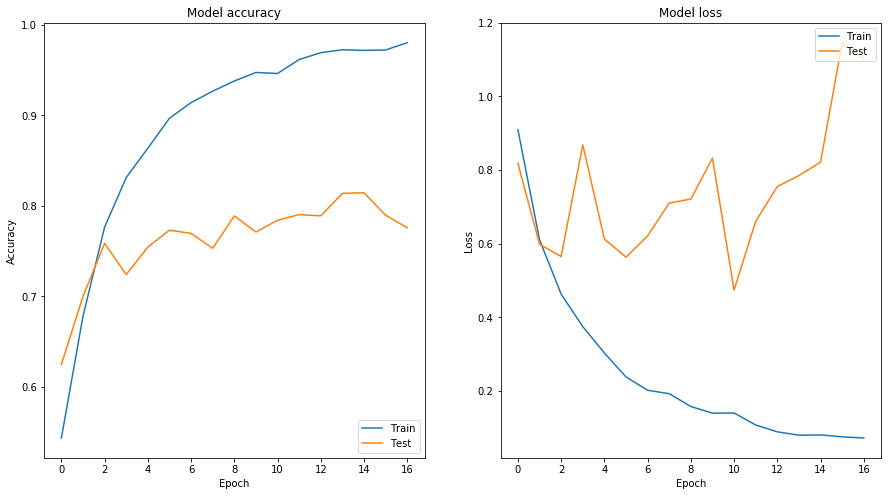

In [16]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))

# Plot training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model accuracy')
ax1.set(xlabel="Epoch", ylabel="Accuracy")
ax1.legend(['Train', 'Test'], loc='lower right')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(xlabel="Epoch", ylabel="Loss")
ax2.legend(['Train', 'Test'], loc='upper right')

plt.show()

In [17]:
predictions = model.predict(trainX)

In [18]:
metrics.log_loss(trainY[:,0],predictions[:,0])

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


nan

In [ ]:
trainY[:,0],predictions[:,0]

In [19]:
memory_report()

vms =  11952
rss =  2615
data =  9762


In [ ]:
gc.collect()